In [5]:
from loguru import logger
import io3d
import io3d.datasets
import sed3
import numpy as np
import matplotlib.pyplot as plt
logger.enable("io3d")
logger.disable("io3d")
import matplotlib.pyplot as plt

import sys
import os
print(sys.version_info)
print(sys.executable)
print(os.getcwd())

sys.version_info(major=3, minor=8, micro=6, releaselevel='final', serial=0)
/home/mjirik/.conda/envs/ml/bin/python
/home/mjirik/projects/lisa/devel


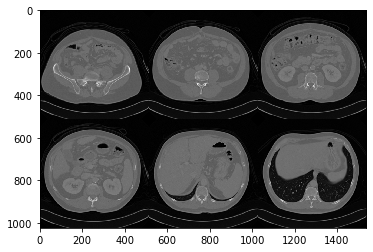

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [50]:
# datap1 = io3d.datasets.read_dataset("3Dircadb1", "data3d", 1)
datap1 = io3d.datasets.read_dataset("sliver07", "data3d", 1)
data3d = datap1["data3d"]
sed3.show_slices(data3d, shape=[2,3])
plt.figure()



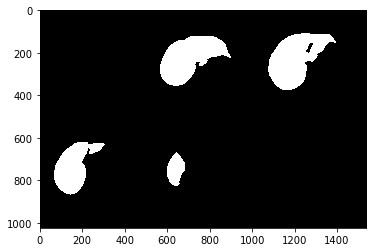

In [75]:
datap1 = io3d.datasets.read_dataset("3Dircadb1", "liver", 1)
data3d = datap1["data3d"]
sed3.show_slices(data3d, shape=[2,3])
# plt.figure()

(129, 512, 512, 2)


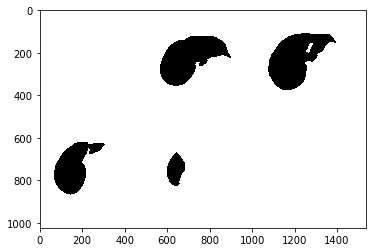

In [76]:
data_oh = tf.one_hot(data3d, 2)
print(data_oh.shape)
# print(data_oh)
sed3.show_slices(data_oh.numpy()[:,:,:,0].squeeze(), shape=[2,3])

## windowing

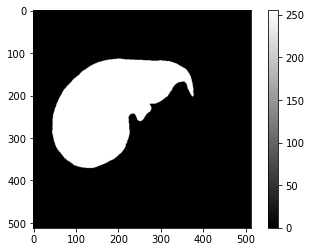

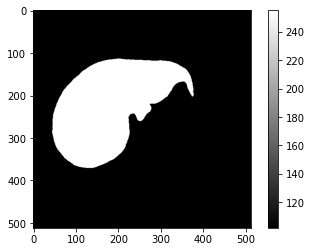

In [8]:
from typing import Optional
from numbers import Number

def window(
        data3d:np.ndarray,
        vmin:Optional[Number]=None,
        vmax:Optional[Number]=None,
        center:Optional[Number]=None,
        width:Optional[Number]=None,
        vmin_out:Optional[Number]=0,
        vmax_out:Optional[Number]=255,
        dtype=np.uint8):
    """
    Rescale input ndarray and trim the outlayers.

    :param data3d: ndarray with numbers
    :param vmin: minimal input value. Skipped if center and width is given.
    :param vmax: maximal input value. Skipped if center and width is given.
    :param center: Window center
    :param width: Window width
    :param vmin_out: Output mapping minimal value
    :param vmax_out: Output mapping maximal value
    :param dtype: Output dtype
    :return:
    """
    if width and center:
        vmin = center - (width / 2.)
        vmax = center + (width / 2.)

#     logger.debug(f"vmin={vmin}, vmax={vmax}")
    k = float(vmax_out - vmin_out) / (vmax - vmin)
    q = vmax_out - k * vmax
#     logger.debug(f"k={k}, q={q}")
    data3d_out = data3d * k + q

    data3d_out[data3d_out > vmax_out] = vmax_out
    data3d_out[data3d_out < vmin_out] = vmin_out

    return data3d_out.astype(dtype)



data3dw = window(data3d, center=40, width=400)
# fix, axs = plt.subplots(1,2)
# axs[]

plt.imshow(data3d[30,:,:], cmap='gray')
plt.colorbar()


plt.figure()

plt.imshow(data3dw[30,:,:], cmap='gray')
plt.colorbar()







In [9]:
def create_train_data(label="train", datasets=None):
    
    imgs_train = [] 
    masks_train = []    
    if not datasets:
        datasets = {
            "3Dircadb1": {"start":1, "stop":2},
            "sliver07": {"start":0, "stop":0}
        }
    for dataset in datasets:
        
        for i in range(
            datasets[dataset]["start"], 
            datasets[dataset]["stop"]
        ):
            print(f"{dataset} {i}")
            data3dp = io3d.datasets.read_dataset(dataset, "data3d", i)
            segm3dp = io3d.datasets.read_dataset(dataset, "liver", i)

            data3d = window(data3dp["data3d"], center=40, width=400, vmin_out=0, vmax_out=255, dtype=np.uint8)
            segm3d = segm3dp["data3d"]

            for j in range(0, data3d.shape[0]):
                imgs_train.append(data3d[j,:,:])
                masks_train.append(segm3d[j,:,:])
                
    imgs_train = np.array(imgs_train, dtype=np.uint8)
    masks_train = np.array(masks_train, dtype=np.uint8)
    np.save(f'imgs_{label}.npy', imgs_train)
    np.save(f'masks_{label}.npy', masks_train)
    print('Saving to .npy files done.')
    return imgs_train, masks_train
            

In [10]:
def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    masks_train = np.load('masks_train.npy')
    return imgs_train, masks_train
def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    masks_test = np.load('masks_test.npy')
    return imgs_test, masks_test

In [51]:
if True:
    create_train_data(
        "train",
        datasets={
#             "3Dircadb1": {"start":1, "stop":3},
            "3Dircadb1": {"start":1, "stop":15},
            "sliver07": {"start":1, "stop":15}
        }
    )
    create_train_data(
        "test",
        datasets={
            "3Dircadb1": {"start":16, "stop":20},
            "sliver07": {"start":16, "stop":20}
        }
    )

3Dircadb1 1
3Dircadb1 2
3Dircadb1 3
3Dircadb1 4
3Dircadb1 5
3Dircadb1 6
3Dircadb1 7
3Dircadb1 8
3Dircadb1 9
3Dircadb1 10
3Dircadb1 11
3Dircadb1 12
3Dircadb1 13
3Dircadb1 14
sliver07 1
sliver07 2
sliver07 3
sliver07 4
sliver07 5
sliver07 6
sliver07 7
sliver07 8
sliver07 9
sliver07 10
sliver07 11
sliver07 12
sliver07 13
sliver07 14
Saving to .npy files done.
3Dircadb1 16
3Dircadb1 17
3Dircadb1 18
3Dircadb1 19
sliver07 16
sliver07 17
sliver07 18
sliver07 19
Saving to .npy files done.


# CNN

'''
conda install -c conda-forge keras-applications
'''

In [12]:

from __future__ import print_function

import tensorflow as tf
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History
from skimage.exposure import rescale_intensity
from skimage import io
# from data import load_train_data, load_test_data
from sklearn.utils import class_weight

In [13]:

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = int(512/2)
img_cols = int(512/2)
smooth = 1.
#We divide here the number of rows and columns by two because we undersample our data (We take one pixel over two)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#The functions return our metric and loss

In [14]:
# one_weight = (1-num_of_ones)/(num_of_ones + num_of_zeros)
# zero_weight = (1-num_of_zeros)/(num_of_ones + num_of_zeros)

def weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true, y_pred)

        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [15]:
# wbc = weighted_binary_crossentropy(0.5, 0.5)
# u = wbc(np.array([1,1,0,1], dtype=np.float32).reshape(4,1,1,1), np.array([1,1,0,1], dtype=np.float32).reshape(4,1,1,1))


In [16]:
def get_unet(weights=None):
    if weights is None:
        weights = [0.05956, 3.11400]
        #{0: 0.5956388648542532, 1: 3.1140000760253925}
    
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
#     conv10 = Conv2D(2, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

#     model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
#     model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=[dice_coef, "accuracy"])
    model.compile(optimizer='adam',  loss=weighted_binary_crossentropy(weights[0], weights[1]), metrics=[dice_coef, "accuracy"])
    #model.compile(optimizer='adam',  loss=weighted_binary_crossentropy(weights[0], weights[1]), metrics=[dice_coef, "accuracy"])  # categorical crossentropy (weighted)
   

    return model

#The different layers in our neural network model (including convolutions, maxpooling and upsampling)

In [17]:
def preprocess(imgs, is_mask=False):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    if is_mask:
        imgs_p = (imgs_p > 0).astype('float32')
        
    else:
        imgs_p = imgs_p.astype('float32')
    return imgs_p

#We adapt here our dataset samples dimension so that we can feed it to our network

In [33]:
def save_segmentations(imgs_test, imgs_mask_test, pred_dir='preds'):
    
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)

    for k in range(len(imgs_mask_test)):
        a=rescale_intensity(imgs_test[k][:,:,0],out_range=(-1,1))
        b=(imgs_mask_test[k][:,:,0] > 0.5).astype('uint8')
        io.imsave(os.path.join(pred_dir, f'{k:05}_pred.png'),mark_boundaries(a,b))

In [34]:
def train_and_predict():
# if True:
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train, is_mask=True)
    
    # TODO remove - using small part of dataset
#     imgs_train = imgs_train[50:65]
#     imgs_mask_train = imgs_mask_train[50:65]

#     imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std
    #Normalization of the train set

#     imgs_mask_train = (imgs_mask_train > 0).astype('float32')
    
    y_train = imgs_mask_train
    # Calculate the weights for each class so that we can balance the data
    weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train.flatten()),
        y_train.flatten()
    )
    print(f"weights={weights}")
    weights_dct = dict(enumerate(weights))

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet(weights)
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
    #Saving the weights and the loss of the best predictions we obtained
    



    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    history=model.fit(
        imgs_train, imgs_mask_train, batch_size=10, epochs=50, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint],
#                 class_weight=weights_dct # tohle nefunguje pro 4d data
                     )

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_maskt = load_test_data()
    imgs_test = preprocess(imgs_test)
    imgs_maskt = preprocess(imgs_maskt, is_mask=True)
    
    
    # TODO remove this limit
#     imgs_test = imgs_test[50:65]
#     imgs_maskt = imgs_maskt[50:65]
    

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std
    #Normalization of the test set
    
    # TODO remove this part
    # going to test on train set
#     imgs_test = imgs_train
#     imgs_maskt = imgs_mask_train

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    
    #Saving our predictions in the directory 'preds'
    save_segmentations(imgs_test, imgs_mask_test)
    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plotting our dice coeff results in function of the number of epochs
    
    return imgs_train, imgs_mask_train

In [30]:
f"__{10:04}.png"

'__0010.png'

In [201]:
# weights_dct

In [ ]:
uu = train_and_predict()

------------------------------
Loading and preprocessing train data...
------------------------------
weights=[0.5294006  9.00322746]
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Epoch 1/50
160/160 [==============================] - 1370s 9s/step - loss: 0.2532 - dice_coef: 0.4006 - accuracy: 0.8637 - val_loss: 0.2397 - val_dice_coef: 0.2771 - val_accuracy: 0.8492
Epoch 2/50
160/160 [==============================] - 1368s 9s/step - loss: 0.2021 - dice_coef: 0.4720 - accuracy: 0.8891 - val_loss: 0.2253 - val_dice_coef: 0.2813 - val_accuracy: 0.8158
Epoch 3/50
160/160 [==============================] - 1368s 9s/step - loss: 0.1374 - dice_coef: 0.5663 - accuracy: 0.9273 - val_loss: 0.1282 - val_dice_coef: 0.3768 - val_accuracy: 0.9356
Epoch 4/50
160/160 [==============================] - 1368s 9s/step - loss: 0.0929 - dice_coef: 0.6764 - accuracy: 0.9579 - val_l

# Try one image

In [77]:
imgs_train, imgs_mask_train = load_train_data()

imgs_train = preprocess(imgs_train)
imgs_mask_train = preprocess(imgs_mask_train)

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std
#Normalization of the train set

imgs_mask_train = imgs_mask_train.astype('float32')

print(f"Number of frames={imgs_train.shape[0]}")


Number of frames=4731


In [53]:
model = get_unet()

model.load_weights('weights.h5')

print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
imgs_mask_train_pred = model.predict(imgs_train, verbose=1)

------------------------------
Predicting masks on test data...
------------------------------
42/42 [==============================] - 283s 7s/step


In [54]:
import scipy.stats

scipy.stats.describe(imgs_mask_train_pred.flatten())

DescribeResult(nobs=86769664, minmax=(4.5916635e-15, 1.0), mean=0.06943986, variance=0.0580671, skewness=3.4010958671569824, kurtosis=9.822672437241263)

In [43]:
i = 13

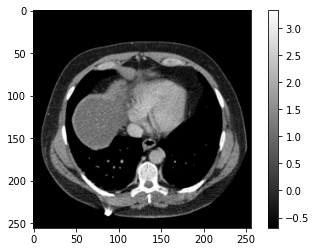

In [44]:
plt.imshow(imgs_train[i,:,:], cmap='gray')
plt.colorbar()

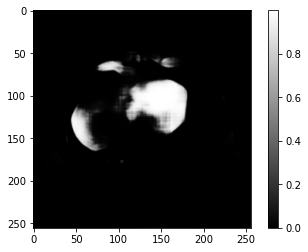

In [45]:
plt.imshow(imgs_mask_train_pred[i,:,:], cmap='gray')
plt.colorbar()

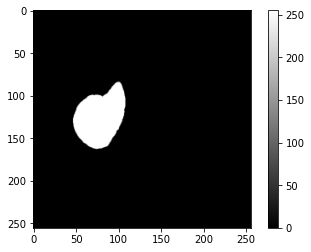

In [46]:
plt.imshow(imgs_mask_train[i,:,:], cmap='gray')
plt.colorbar()

In [47]:
tf.keras.losses.binary_crossentropy(imgs_mask_train[i,:,:].flatten(), imgs_mask_train_pred[i,:,:].flatten())

<tf.Tensor: shape=(), dtype=float32, numpy=39.80838>

In [1]:
tf.keras.losses.binary_crossentropy(imgs_mask_train.flatten(), imgs_mask_train_pred.flatten())

NameError: name 'tf' is not defined

In [55]:
save_segmentations(imgs_train, imgs_mask_train_pred, "pred_test")

Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

In [27]:
y_train=(imgs_mask_train > 0).astype(np.float32)
weights = class_weight.compute_class_weight('balanced', np.unique(y_train.flatten()), y_train.flatten())
# y_train.shape
# imgs_train.shape
# y_train.dtype
# print(np.unique(imgs_mask_train > 0))

# plt.imshow(imgs_mask_train[150,:,:] > 0, interpolation='None')
print(weights)

/home/mjirik/.conda/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[0.5294006  9.00322746]
